In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Espírito Santo - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_ES.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Espírito Santo - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Espírito Santo - IDH,Espírito Santo - Consumo de Cimento (t),Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - value
0,2003-1,8.177444,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.760059,48.426,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,0.268445
1,2003-2,8.171622,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.760222,54.969,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,0.270512
2,2003-3,8.165799,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.760385,53.847,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,0.271941
3,2003-4,8.159977,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.760548,50.375,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,0.273321
4,2003-5,8.154154,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.760710,52.576,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,0.274453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.170,NaN,NaN,NaN,NaN,66.919726,0.505935
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.832,NaN,NaN,NaN,NaN,66.756019,0.504835
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.318,NaN,NaN,NaN,NaN,66.684567,0.502971
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.187,NaN,NaN,NaN,NaN,66.664258,0.500670


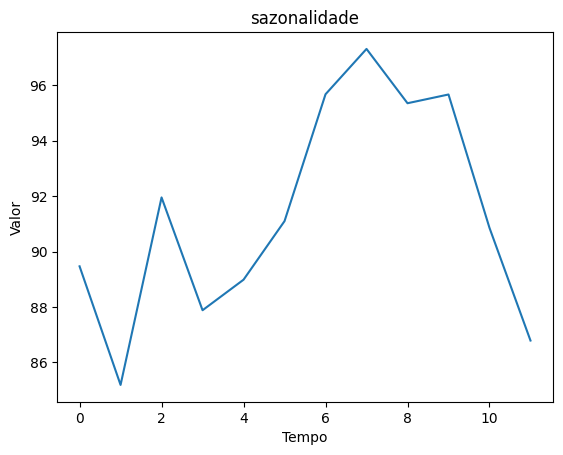

,sazonalidade
sazonalidade,
0,89.465214
1,85.182786
2,91.952893
3,87.879286
4,88.982286
5,91.097643
6,95.678214
7,97.315286
8,95.354071


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Espírito Santo - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Espírito Santo - IDH,Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - value,sazonalidade,Espírito Santo - Consumo de Cimento (t)
0,2003-1,8.177444,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.760059,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,0.268445,89.465214,48.426
1,2003-2,8.171622,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.760222,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,0.270512,85.182786,54.969
2,2003-3,8.165799,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.760385,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,0.271941,91.952893,53.847
3,2003-4,8.159977,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.760548,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,0.273321,87.879286,50.375
4,2003-5,8.154154,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.760710,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,0.274453,88.982286,52.576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.919726,0.505935,97.315286,100.170
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.756019,0.504835,95.354071,85.832
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.684567,0.502971,95.669857,91.318
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.664258,0.500670,90.853286,77.187


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      56.490
1      53.578
2      60.481
3      64.833
4      64.063
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Espírito Santo - Consumo de Cimento (t), Length: 240, dtype: float64

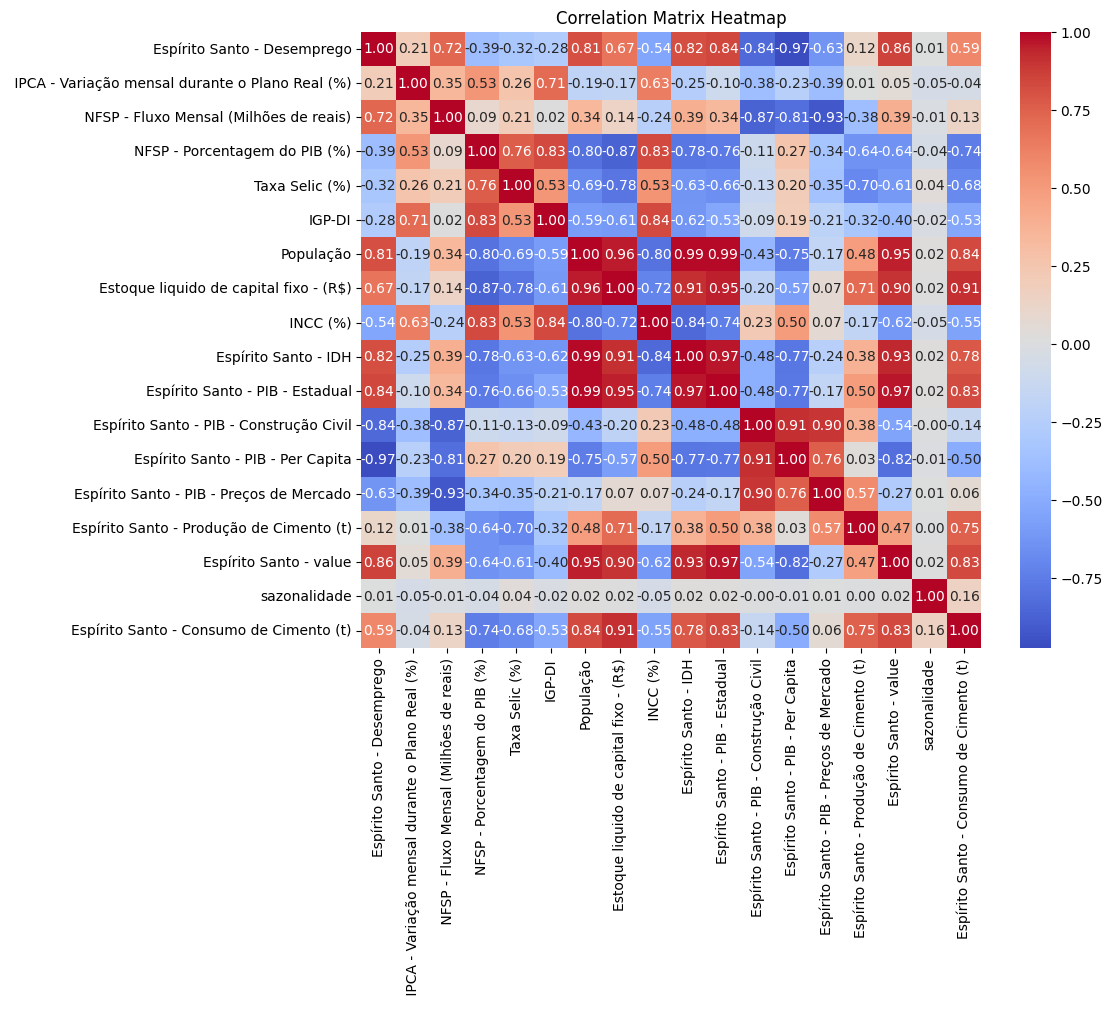

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Espírito Santo - Desemprego,7.901851e+03
1,IPCA - Variação mensal durante o Plano Real (%),2.820361e+03
2,NFSP - Fluxo Mensal (Milhões de reais),3.197281e+02
3,NFSP - Porcentagem do PIB (%),1.397828e+02
4,Taxa Selic (%),5.492711e+01
5,IGP-DI,3.639706e+02
6,População,6.178517e+06
7,Estoque liquido de capital fixo - (R$),1.834526e+07
8,INCC (%),2.283368e+03
9,Espírito Santo - IDH,6.172489e+06


In [39]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 0


,Espírito Santo - Desemprego,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Espírito Santo - IDH,Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - value,sazonalidade
0,8.177444,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.760059,6.342537e+07,3.523987e+06,16.799308,5.948249e+07,98.171240,0.268445,89.465214
1,8.171622,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.760222,6.350834e+07,3.527412e+06,16.807398,5.951949e+07,97.897317,0.270512,85.182786
2,8.165799,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.760385,6.359131e+07,3.530838e+06,16.815488,5.955649e+07,98.070539,0.271941,91.952893
3,8.159977,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.760548,6.367428e+07,3.534263e+06,16.823577,5.959349e+07,98.460789,0.273321,87.879286
4,8.154154,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.760710,6.375725e+07,3.537689e+06,16.831667,5.963048e+07,99.084134,0.274453,88.982286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,10.327823,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,0.778937,7.287388e+07,3.502700e+06,16.535554,5.984963e+07,102.625990,0.371395,97.315286
176,10.310550,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,0.778929,7.289170e+07,3.504094e+06,16.541044,5.986613e+07,99.969898,0.371461,95.354071
177,10.293277,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,0.778922,7.290952e+07,3.505489e+06,16.546534,5.988263e+07,97.572861,0.371526,95.669857
178,10.276004,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,0.778914,7.292733e+07,3.506884e+06,16.552023,5.989913e+07,94.929951,0.371590,90.853286


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Espírito Santo - IDH,Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - value
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.977973,-1.872410,-1.010041,0.011508,-1.852217,-1.540384,-1.234089
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.947702,-1.844997,-0.959209,0.051647,-1.756439,-1.547448,-1.185528
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.917430,-1.817583,-0.908378,0.091786,-1.660662,-1.542981,-1.151932
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.887159,-1.790169,-0.857547,0.131925,-1.564885,-1.532917,-1.119518
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.856887,-1.762755,-0.806715,0.172064,-1.469108,-1.516842,-1.092919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,1.532306,1.249405,-1.325920,-1.297143,-0.901798,-1.425502,1.184936
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,1.530884,1.255291,-1.305224,-1.269905,-0.859088,-1.493999,1.186489
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,1.529462,1.261178,-1.284529,-1.242668,-0.816378,-1.555816,1.188015
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,1.528040,1.267064,-1.263833,-1.215430,-0.773667,-1.623973,1.189518


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Espírito Santo - IDH,Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - value
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.977973,-1.872410,-1.010041,0.011508,-1.852217,-1.540384,-1.234089
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.947702,-1.844997,-0.959209,0.051647,-1.756439,-1.547448,-1.185528
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.917430,-1.817583,-0.908378,0.091786,-1.660662,-1.542981,-1.151932
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.887159,-1.790169,-0.857547,0.131925,-1.564885,-1.532917,-1.119518
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.856887,-1.762755,-0.806715,0.172064,-1.469108,-1.516842,-1.092919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,1.542321,1.154955,-1.517461,-1.601162,-1.412511,-0.661324,1.145319
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,1.542308,1.165603,-1.508127,-1.578491,-1.370163,-0.725525,1.151390
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,1.542296,1.176252,-1.498793,-1.555821,-1.327815,-0.789018,1.157082
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,1.542284,1.186901,-1.489458,-1.533150,-1.285467,-0.850802,1.165365


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       56.490
1       53.578
2       60.481
3       64.833
4       64.063
        ...   
163    107.106
164    101.893
165    110.551
166    100.587
167     94.220
Name: Espírito Santo - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 15)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Espírito Santo - IDH,Espírito Santo - PIB - Estadual,Espírito Santo - PIB - Construção Civil,Espírito Santo - PIB - Per Capita,Espírito Santo - PIB - Preços de Mercado,Espírito Santo - Produção de Cimento (t),Espírito Santo - value
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,0.676938,1.020303,-0.856107,-0.966087,-0.292740,0.850480,1.012282
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,0.679955,1.020119,-0.893635,-1.017865,-0.385516,0.813032,1.019414
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,0.682973,1.019936,-0.931164,-1.069643,-0.478292,0.773028,1.026185
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,0.685991,1.019752,-0.968692,-1.121422,-0.571068,0.732077,1.032588
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,0.689009,1.019569,-1.006220,-1.173200,-0.663844,0.690690,1.038613
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,0.692026,1.019385,-1.043749,-1.224978,-0.756621,0.648675,1.044253
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,0.695044,1.019202,-1.081277,-1.276756,-0.849397,0.605878,1.049579
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,0.698062,1.019018,-1.118806,-1.328535,-0.942173,0.562410,1.054645
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,0.701080,1.018835,-1.156334,-1.380313,-1.034949,0.518428,1.060450
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,0.704097,1.018651,-1.193862,-1.432091,-1.127725,0.473705,1.066054


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 15)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1622274724, 2405376216, 3878739028, 918825136, 3976103727, 179307818, 3458097592, 3785133132, 478912352, 3965627236]


Step: 0 ___________________________________________
val_loss: 118.1770248413086
winner_seed: 1622274724


Step: 1 ___________________________________________
val_loss: 113.90663146972656
winner_seed: 2405376216


Step: 2 ___________________________________________
val_loss: 108.79176330566406
winner_seed: 3878739028


Step: 3 ___________________________________________
val_loss: 129.63265991210938


Step: 4 ___________________________________________
val_loss: 120.63603210449219


Step: 5 ___________________________________________
val_loss: 106.74433898925781
winner_seed: 179307818


Step: 6 ___________________________________________
val_loss: 111.52437591552734


Step: 7 ___________________________________________
val_loss: 110.8369369506836


Step: 8 ___________________________________________
val_loss: 113.13938903808594


Step: 9 ________________________________

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 2791720715

Epoch 1/10000
4/4 [==============================] - 2s 134ms/step - loss: 10021.8770 - val_loss: 1640.3434
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 1400.0361 - val_loss: 124.6495
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 158.7443 - val_loss: 194.7139
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 114.3498 - val_loss: 259.2062
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 109.3696 - val_loss: 262.0130
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.2562 - val_loss: 267.6461
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 1605.1277 - val_loss: 205.8855
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 115.7226 - val_loss: 274.4678
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 107.6654 - val_loss: 274.3018
Epoch 10/10000
4/4 [==============================] - 0s 9ms/step 

4/4 [==============================] - 0s 9ms/step - loss: 84.0042 - val_loss: 146.3611
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 82.0939 - val_loss: 167.4039
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 82.5008 - val_loss: 149.3763
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 83.7837 - val_loss: 162.2187
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.5577 - val_loss: 151.5245
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.8899 - val_loss: 144.1869
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 91.3146 - val_loss: 143.9105
Epoch 87/10000
4/4 [==============================] - 0s 8ms/step - loss: 87.9340 - val_loss: 146.6174
Epoch 88/10000
4/4 [==============================] - 0s 10ms/step - loss: 82.8549 - val_loss: 136.6609
Epoch 89/10000
4/4 [==============================] - 0s 9ms/step - loss: 82.4286 - val

4/4 [==============================] - 0s 9ms/step - loss: 76.6157 - val_loss: 121.4439
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 78.8879 - val_loss: 120.6292
Epoch 161/10000
4/4 [==============================] - 0s 9ms/step - loss: 81.1477 - val_loss: 118.9769
Epoch 162/10000
4/4 [==============================] - 0s 9ms/step - loss: 83.5386 - val_loss: 123.7987
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 79.3680 - val_loss: 127.0836
Epoch 164/10000
4/4 [==============================] - 0s 9ms/step - loss: 76.2351 - val_loss: 128.4456
Epoch 165/10000
4/4 [==============================] - 0s 9ms/step - loss: 79.0632 - val_loss: 120.1780
Epoch 166/10000
4/4 [==============================] - 0s 9ms/step - loss: 78.0319 - val_loss: 123.2679
Epoch 167/10000
4/4 [==============================] - 0s 8ms/step - loss: 78.8677 - val_loss: 121.6244
Epoch 168/10000
4/4 [==============================] - 0s 8ms/step - loss: 75.6

Epoch 238/10000
4/4 [==============================] - 0s 9ms/step - loss: 67.3250 - val_loss: 111.8535
Epoch 239/10000
4/4 [==============================] - 0s 9ms/step - loss: 65.8307 - val_loss: 111.7163
Epoch 240/10000
4/4 [==============================] - 0s 9ms/step - loss: 67.8675 - val_loss: 112.1256
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 63.9269 - val_loss: 112.7654
Epoch 242/10000
4/4 [==============================] - 0s 11ms/step - loss: 70.7726 - val_loss: 117.0139
Epoch 243/10000
4/4 [==============================] - 0s 9ms/step - loss: 67.6636 - val_loss: 117.4026
Epoch 244/10000
4/4 [==============================] - 0s 10ms/step - loss: 66.7107 - val_loss: 117.1141
Epoch 245/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.9201 - val_loss: 113.4536
Epoch 246/10000
4/4 [==============================] - 0s 11ms/step - loss: 67.4497 - val_loss: 115.4718
Epoch 247/10000
4/4 [==============================] - 0s 10

4/4 [==============================] - 0s 8ms/step - loss: 58.0464 - val_loss: 118.8861
Epoch 317/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.9385 - val_loss: 122.0361
Epoch 318/10000
4/4 [==============================] - 0s 8ms/step - loss: 64.3127 - val_loss: 119.2446
Epoch 319/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.9104 - val_loss: 123.7260
Epoch 320/10000
4/4 [==============================] - 0s 9ms/step - loss: 59.7541 - val_loss: 121.0399
Epoch 321/10000
4/4 [==============================] - 0s 8ms/step - loss: 60.7917 - val_loss: 122.3861
Epoch 322/10000
4/4 [==============================] - 0s 8ms/step - loss: 60.3170 - val_loss: 120.8832
Epoch 323/10000
4/4 [==============================] - 0s 8ms/step - loss: 57.9458 - val_loss: 118.6992
Epoch 324/10000
4/4 [==============================] - 0s 8ms/step - loss: 59.5135 - val_loss: 119.7776
Epoch 325/10000
4/4 [==============================] - 0s 8ms/step - loss: 60.13

Epoch 395/10000
4/4 [==============================] - 0s 9ms/step - loss: 60.2161 - val_loss: 128.1443
Epoch 396/10000
4/4 [==============================] - 0s 9ms/step - loss: 61.0283 - val_loss: 123.7257
Epoch 397/10000
4/4 [==============================] - 0s 10ms/step - loss: 56.5869 - val_loss: 124.9877
Epoch 398/10000
4/4 [==============================] - 0s 9ms/step - loss: 60.3547 - val_loss: 122.1737
Epoch 399/10000
4/4 [==============================] - 0s 9ms/step - loss: 56.0663 - val_loss: 124.8138
Epoch 400/10000
4/4 [==============================] - 0s 9ms/step - loss: 55.6301 - val_loss: 121.2929
Epoch 401/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.1428 - val_loss: 123.8400
Epoch 402/10000
4/4 [==============================] - 0s 8ms/step - loss: 59.6914 - val_loss: 122.2665
Epoch 403/10000
4/4 [==============================] - 0s 8ms/step - loss: 58.5909 - val_loss: 122.6800
Epoch 404/10000
4/4 [==============================] - 0s 10ms/

4/4 [==============================] - 0s 9ms/step - loss: 51.1909 - val_loss: 114.1144
Epoch 474/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.1393 - val_loss: 114.7591
Epoch 475/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.4262 - val_loss: 113.7895
Epoch 476/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.3745 - val_loss: 112.3063
Epoch 477/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.6676 - val_loss: 113.8519
Epoch 478/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.9532 - val_loss: 110.0022
Epoch 479/10000
4/4 [==============================] - 0s 9ms/step - loss: 55.6801 - val_loss: 112.1351
Epoch 480/10000
4/4 [==============================] - 0s 10ms/step - loss: 49.9990 - val_loss: 114.4405
Epoch 481/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.6754 - val_loss: 114.9171
Epoch 482/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.1

4/4 [==============================] - 0s 9ms/step - loss: 49.9195 - val_loss: 111.7151
Epoch 552/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.2523 - val_loss: 111.2058
Epoch 553/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.6401 - val_loss: 112.4588
Epoch 554/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.6117 - val_loss: 111.7931
Epoch 555/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.3112 - val_loss: 112.1491
Epoch 556/10000
4/4 [==============================] - 0s 8ms/step - loss: 51.3078 - val_loss: 111.9892
Epoch 557/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.7356 - val_loss: 110.8991
Epoch 558/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.5824 - val_loss: 111.5145
Epoch 559/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.7502 - val_loss: 111.8248
Epoch 560/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.09

4/4 [==============================] - 0s 8ms/step - loss: 42.9031 - val_loss: 109.1815
Epoch 630/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.4389 - val_loss: 110.1133
Epoch 631/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.7238 - val_loss: 109.1890
Epoch 632/10000
4/4 [==============================] - 0s 9ms/step - loss: 44.5229 - val_loss: 109.0702
Epoch 633/10000
4/4 [==============================] - 0s 9ms/step - loss: 46.7144 - val_loss: 110.5979
Epoch 634/10000
4/4 [==============================] - 0s 10ms/step - loss: 47.4557 - val_loss: 108.9819
Epoch 635/10000
4/4 [==============================] - 0s 9ms/step - loss: 44.9124 - val_loss: 108.7491
Epoch 636/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.3672 - val_loss: 111.7707
Epoch 637/10000
4/4 [==============================] - 0s 8ms/step - loss: 52.8130 - val_loss: 112.1949
Epoch 638/10000
4/4 [==============================] - 0s 8ms/step - loss: 53.

Epoch 708/10000
4/4 [==============================] - 0s 9ms/step - loss: 56.1455 - val_loss: 124.3733
Epoch 709/10000
4/4 [==============================] - 0s 9ms/step - loss: 56.4872 - val_loss: 130.8415
Epoch 710/10000
4/4 [==============================] - 0s 9ms/step - loss: 57.9668 - val_loss: 126.8621
Epoch 711/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.7594 - val_loss: 122.0677
Epoch 712/10000
4/4 [==============================] - 0s 9ms/step - loss: 63.8177 - val_loss: 130.3790
Epoch 713/10000
4/4 [==============================] - 0s 9ms/step - loss: 55.1571 - val_loss: 130.2893
Epoch 714/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.9368 - val_loss: 122.3841
Epoch 715/10000
4/4 [==============================] - 0s 9ms/step - loss: 52.7864 - val_loss: 126.1885
Epoch 716/10000
4/4 [==============================] - 0s 9ms/step - loss: 58.9202 - val_loss: 134.3932
Epoch 717/10000
4/4 [==============================] - 0s 8ms/st

4/4 [==============================] - 0s 9ms/step - loss: 52.6806 - val_loss: 135.0978
Epoch 787/10000
4/4 [==============================] - 0s 8ms/step - loss: 57.6871 - val_loss: 138.7164
Epoch 788/10000
4/4 [==============================] - 0s 9ms/step - loss: 58.5803 - val_loss: 132.2905
Epoch 789/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.1184 - val_loss: 126.3610
Epoch 790/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.7381 - val_loss: 127.7593
Epoch 791/10000
4/4 [==============================] - 0s 9ms/step - loss: 53.3055 - val_loss: 129.0712
Epoch 792/10000
4/4 [==============================] - 0s 9ms/step - loss: 53.0442 - val_loss: 130.4276
Epoch 793/10000
4/4 [==============================] - 0s 8ms/step - loss: 50.3113 - val_loss: 131.7145
Epoch 794/10000
4/4 [==============================] - 0s 9ms/step - loss: 49.1222 - val_loss: 137.6935
Epoch 795/10000
4/4 [==============================] - 0s 9ms/step - loss: 48.14

Epoch 865/10000
4/4 [==============================] - 0s 9ms/step - loss: 46.5632 - val_loss: 148.8409
Epoch 866/10000
4/4 [==============================] - 0s 9ms/step - loss: 47.0885 - val_loss: 145.9030
Epoch 867/10000
4/4 [==============================] - 0s 9ms/step - loss: 46.2303 - val_loss: 150.8257
Epoch 868/10000
4/4 [==============================] - 0s 8ms/step - loss: 45.7838 - val_loss: 154.0194
Epoch 869/10000
4/4 [==============================] - 0s 8ms/step - loss: 43.5186 - val_loss: 146.6412
Epoch 870/10000
4/4 [==============================] - 0s 8ms/step - loss: 45.8885 - val_loss: 147.0470
Epoch 871/10000
4/4 [==============================] - 0s 9ms/step - loss: 45.3887 - val_loss: 159.3580
Epoch 872/10000
4/4 [==============================] - 0s 9ms/step - loss: 43.5279 - val_loss: 152.1611
Epoch 873/10000
4/4 [==============================] - 0s 8ms/step - loss: 45.8634 - val_loss: 147.6419
Epoch 874/10000
4/4 [==============================] - 0s 9ms/st

4/4 [==============================] - 0s 9ms/step - loss: 41.0672 - val_loss: 169.5754
Epoch 944/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.9505 - val_loss: 173.5712
Epoch 945/10000
4/4 [==============================] - 0s 8ms/step - loss: 40.4069 - val_loss: 175.0154
Epoch 946/10000
4/4 [==============================] - 0s 9ms/step - loss: 41.7945 - val_loss: 184.2413
Epoch 947/10000
4/4 [==============================] - 0s 9ms/step - loss: 40.3303 - val_loss: 181.0062
Epoch 948/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.3026 - val_loss: 182.0264
Epoch 949/10000
4/4 [==============================] - 0s 9ms/step - loss: 34.7736 - val_loss: 166.2217
Epoch 950/10000
4/4 [==============================] - 0s 9ms/step - loss: 36.9810 - val_loss: 167.8082
Epoch 951/10000
4/4 [==============================] - 0s 9ms/step - loss: 40.3343 - val_loss: 177.9872
Epoch 952/10000
4/4 [==============================] - 0s 10ms/step - loss: 44.8

4/4 [==============================] - 0s 7ms/step - loss: 35.7870 - val_loss: 178.0065
Epoch 1022/10000
4/4 [==============================] - 0s 7ms/step - loss: 34.2581 - val_loss: 186.8292
Epoch 1023/10000
4/4 [==============================] - 0s 8ms/step - loss: 37.3769 - val_loss: 171.9074
Epoch 1024/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.8689 - val_loss: 173.7372
Epoch 1025/10000
4/4 [==============================] - 0s 8ms/step - loss: 35.2614 - val_loss: 180.5618
Epoch 1026/10000
4/4 [==============================] - 0s 8ms/step - loss: 35.3879 - val_loss: 190.3089
Epoch 1027/10000
4/4 [==============================] - 0s 7ms/step - loss: 34.0613 - val_loss: 183.7873
Epoch 1028/10000
4/4 [==============================] - 0s 8ms/step - loss: 37.6514 - val_loss: 187.7841
Epoch 1029/10000
4/4 [==============================] - 0s 8ms/step - loss: 36.7844 - val_loss: 214.2500
Epoch 1030/10000
4/4 [==============================] - 0s 7ms/step - lo

4/4 [==============================] - 0s 7ms/step - loss: 30.5399 - val_loss: 172.7430
Epoch 1100/10000
4/4 [==============================] - 0s 7ms/step - loss: 29.7693 - val_loss: 170.3551
Epoch 1101/10000
4/4 [==============================] - 0s 7ms/step - loss: 28.9491 - val_loss: 173.2822
Epoch 1102/10000
4/4 [==============================] - 0s 7ms/step - loss: 31.6557 - val_loss: 187.2517
Epoch 1103/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.6769 - val_loss: 174.2677
Epoch 1104/10000
4/4 [==============================] - 0s 7ms/step - loss: 26.9951 - val_loss: 173.0435
Epoch 1105/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.9005 - val_loss: 169.3720
Epoch 1106/10000
4/4 [==============================] - 0s 7ms/step - loss: 35.6868 - val_loss: 173.8185
Epoch 1107/10000
4/4 [==============================] - 0s 7ms/step - loss: 30.5617 - val_loss: 163.6909
Epoch 1108/10000
4/4 [==============================] - 0s 7ms/step - lo

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 13ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,97.359596,98.684288,97.290672,98.41687,97.804581,98.55188,96.626564,99.718201,97.455933,98.537491,97.643013,98.233955
Target,111.377,98.614,94.022,91.546,95.674,88.927,105.688,104.711,97.53,99.651,76.71,75.456
Error,14.017403,0.07029,3.268669,6.870872,2.130577,9.624878,9.06144,4.992798,0.074066,1.11351,20.933014,22.777954


In [54]:
display(mae)
display(mape)

7.911289

0.090583175

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[1176.3231]] - Target[1139.9059999999997]| =  Error: [[36.417114]]; MAPE:[[0.03194747]]


[array([[36.417114]], dtype=float32)]

36.417114

0.03194747